# 2021/22 Climate Change Belief Analysis

Predict an individual’s belief in climate change based on historical tweet data.
Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.



# Overview
* Data Collection
   * Load packages and data
   * Reading the data
* Data Cleaning
   * Data information
   * Checking for Nulls values
   * Removing stopwords 
   * Removing Noise
   * Tokenisation
   * Lemmatization
* Exploratory data analysis
   * Plots to shows analysis of our data
* Model Building
   * Feature Engineering 
   * Feature Generation using Bag of words
   * Split train and test set
   * Model Building and evaluation
* Model Deployment
   * Saving a model with pickel
   * Preprocessing: Predicting on the test set
   * Making Predictions
   * submission
* Conclusion

## 1. Data Collection

The collection of this data was funded by a Canada Foundation for Innovation JELF Grant to Chris Bauch, University of Waterloo. The dataset aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, `43943` tweets were collected. Each tweet `sentiment` is labelled as one of the following:

* 2 - **News**: the tweet links to factual news about climate change 
* 1 - **Pro**: the tweet supports the belief of man-made climate change 
* 0 - **Neutral**: the tweet neither supports nor refutes the belief of man-made climate change
* -1 - **Anti**: the tweet does not believe in man-made climate change

Variable definitions <br>
* **tweetid**: Twitter unique id
* **message**: Message of a tweet
* **sentiment**: Sentiment of tweet message

### 1.1 Loading packages and data
First step, is to install and import the necessary Python packages and load the input data as a Pandas dataframe.

#### Installing dependencies

`To avoid getting errors run the code on Anaconda Prompt`
``` python
conda config --add channels conda-forge
conda install pyahocorasick
```

In [4]:
import warnings
warnings.filterwarnings("ignore")

!pip install inflect
!pip install wordcloud
!pip install contractions
!pip install squarify


  Using cached contractions-0.0.58-py2.py3-none-any.whl (8.0 kB)
  Using cached textsearch-0.0.21-py2.py3-none-any.whl (7.5 kB)
  Using cached anyascii-0.3.0-py3-none-any.whl (284 kB)


#### Importing libraries

In [5]:
# data manipulation
import numpy as np
import pandas as pd
import re
import urllib
import string
import unicodedata
import inflect
import contractions
import squarify
import pickle

# visualizations 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Data preprocessing
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Performance check
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to C:\Users\Ntokozo
[nltk_data]     Thumre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.2 Reading in the data
We chose to combine the train and test set into one since we want to clean both data at the same time. However, there is no risk on mixing them together. Test data does not have a sentiment column. Therefore, it will be easy to sepate them when we finish data cleaning.

In [7]:
# Load data as Pandas dataframe
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test_with_no_labels.csv')

# we will use later
train_EDA = train_df.copy() 

In [8]:
# Print 1st 5 rows of the data
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [9]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [10]:
#Prints the last 5 rows
train_df.tail()

,sentiment,message,tweetid
15814,1,RT @ezlusztig: They took down the material on ...,22001
15815,2,RT @washingtonpost: How climate change could b...,17856
15816,0,notiven: RT: nytimesworld :What does Trump act...,384248
15817,-1,RT @sara8smiles: Hey liberals the climate chan...,819732
15818,0,RT @Chet_Cannon: .@kurteichenwald's 'climate c...,806319


In [11]:
test_df.tail()

,message,tweetid
10541,"RT @BrittanyBohrer: Brb, writing a poem about ...",895714
10542,2016: the year climate change came home: Durin...,875167
10543,RT @loop_vanuatu: Pacific countries positive a...,78329
10544,"RT @xanria_00018: You’re so hot, you must be t...",867455
10545,RT @chloebalaoing: climate change is a global ...,470892


In [12]:
# number of rows and columns of the train data set
train_df.shape

(15819, 3)

In [13]:
# number of columns and rows of the test data set
test_df.shape

(10546, 2)

The shape command shows us that our train data has has 15819 rows of data and 3 features and our test data has 10546 rows and 2 rows

## 2. Data Cleaning
before we do anything to the data we need to know what type of data we're working with.

### 2.1 Information about the data

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB


### 2.2 Checking for missing values


In [16]:
train_df.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [13]:
test_df.isnull().sum()

message    0
tweetid    0
dtype: int64

Our data has no missing values

### 2.3 Removing Stopwords

We will first convert all text data into lowercase. If we do not do this, words such as `Climate` and `climate` will be interpreted differently. We will also break down words such as `I'll` into `I will` using `contractions` library. Doing this will help us to remove all the stopwords

In [35]:
#Function used to fix all the contractions from the dictionary
def fixer(text, dictionary):
    
    for word in text.split(): 
        
        if word.lower() in dictionary:
            
            if word.lower() in text.split():
                
                text = text.replace(word, dictionary[word.lower()]) 
    return text


contractions = { 

"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have",
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"it's": "it is",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will"
}



# removing contractions
train_df['message'] = train_df['message'].apply(lambda x: fixer(x,contractions))
test_df['message'] = test_df['message'].apply(lambda x: fixer(x,contractions))


In [36]:
# making all text to lowercase
def lowercase(text):
    text = text.lower() 
    return text

train_df['message'] = train_df['message'].apply(lowercase)

test_df['message'] = test_df['message'].apply(lowercase)

In [37]:
train_df['message'].head()

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired : 2016 was a pivotal year...
4    rt @soynoviodetodas: it is 2016, and a racist,...
Name: message, dtype: object

Alright, now we remove all the english stopwords from our text data

In [38]:
stopwordlist = stopwords.words('english') + ['shouldve', 'shes', 'youre',  'thatll', 'youd', 'youll',  'youve']
stopwordlist = set(stopwordlist)

In [39]:
def cleaning_stopwords(data):
    return " ".join([word for word in str(data).split() if word not in stopwordlist])

In [40]:
train_df['message'] = train_df['message'].apply(lambda x: cleaning_stopwords(x))
test_df['message'] = test_df['message'].apply(lambda x: cleaning_stopwords(x))
train_df['message'].head()

0    polyscimajor epa chief think carbon dioxide ma...
1      like lack evidence anthropogenic global warming
2    rt @rawstory: researchers say three years act ...
3    #todayinmaker# wired : 2016 pivotal year war c...
4    rt @soynoviodetodas: 2016, racist, sexist, cli...
Name: message, dtype: object

### 2.4 Removing Noise
Our data still contains characters we don't want such as punctuations. We will now remove unwanted characters such as emoji's, web urls, puntuations, ... etc.

In [41]:
abbreviations = {"$" : " dollar ", "€" : " euro ", "4ao" : "for adults only", "a.m" : "before midday",
                 "a3" : "anytime anywhere anyplace", "aamof" : "as a matter of fact", "acct" : "account", "adih" : "another day in hell",
                 "afaic" : "as far as i am concerned", "afaict" : "as far as i can tell", "afaik" : "as far as i know",
                 "afair" : "as far as i remember", "afk" : "away from keyboard", "app" : "application", "approx" : "approximately",
                 "apps" : "applications", "asap" : "as soon as possible", "asl" : "age, sex, location", "atk" : "at the keyboard",
                 "ave." : "avenue", "aymm" : "are you my mother", "ayor" : "at your own risk", "b&b" : "bed and breakfast",
                 "b+b" : "bed and breakfast", "b.c" : "before christ", "b2b" : "business to business", "b2c" : "business to customer",
                 "b4" : "before", "b4n" : "bye for now", "b@u" : "back at you", "bae" : "before anyone else", "bak" : "back at keyboard",
                 "bbbg" : "bye bye be good", "bbc" : "british broadcasting corporation", "bbias" : "be back in a second",
                 "bbl" : "be back later", "bbs" : "be back soon", "be4" : "before", "bfn" : "bye for now", "blvd" : "boulevard",
                 "bout" : "about", "brb" : "be right back", "bros" : "brothers", "brt" : "be right there", "bsaaw" : "big smile and a wink",
                 "btw" : "by the way", "bwl" : "bursting with laughter", "c/o" : "care of", "cet" : "central european time",
                 "cf" : "compare", "cia" : "central intelligence agency", "csl" : "can not stop laughing", "cu" : "see you",
                 "cul8r" : "see you later", "cv" : "curriculum vitae", "cwot" : "complete waste of time", "cya" : "see you",
                 "cyt" : "see you tomorrow", "dae" : "does anyone else", "dbmib" : "do not bother me i am busy", "diy" : "do it yourself",
                 "dm" : "direct message", "dwh" : "during work hours", "e123" : "easy as one two three",
                 "eet" : "eastern european time", "eg" : "example", "embm" : "early morning business meeting", "encl" : "enclosed",
                 "encl." : "enclosed", "etc" : "and so on", "faq" : "frequently asked questions", "fawc" : "for anyone who cares",
                 "fb" : "facebook", "fc" : "fingers crossed", "fig" : "figure", "fimh" : "forever in my heart", "ft." : "feet",
                 "ft" : "featuring", "ftl" : "for the loss", "ftw" : "for the win", "fwiw" : "for what it is worth",
                 "fyi" : "for your information", "g9" : "genius", "gahoy" : "get a hold of yourself", "gal" : "get a life",
                 "gcse" : "general certificate of secondary education", "gfn" : "gone for now", "gg" : "good game",
                 "gl" : "good luck", "glhf" : "good luck have fun", "gmt" : "greenwich mean time", "gmta" : "great minds think alike",
                 "gn" : "good night", "g.o.a.t" : "greatest of all time", "goat" : "greatest of all time", "goi" : "get over it",
                 "gps" : "global positioning system", "gr8" : "great", "gratz" : "congratulations", "gyal" : "girl", "h&c" : "hot and cold",
                 "hp" : "horsepower", "hr" : "hour", "hrh" : "his royal highness", "ht" : "height", "ibrb" : "i will be right back",
                 "ic" : "i see", "icq" : "i seek you", "icymi" : "in case you missed it", "idc" : "i do not care",
                 "idgadf" : "i do not give a damn fuck", "idgaf" : "i do not give a fuck", "idk" : "i do not know", "ie" : "that is",
                 "i.e" : "that is", "ifyp" : "i feel your pain", "IG" : "instagram", "iirc" : "if i remember correctly", "ilu" : "i love you",
                 "ily" : "i love you", "imho" : "in my humble opinion", "imo" : "in my opinion", "imu" : "i miss you",
                 "iow" : "in other words", "irl" : "in real life", "j4f" : "just for fun", "jic" : "just in case",
                 "jk" : "just kidding", "jsyk" : "just so you know", "l8r" : "later", "lb" : "pound", "lbs" : "pounds",
                 "ldr" : "long distance relationship", "lmao" : "laugh my ass off", "lmfao" : "laugh my fucking ass off",
                 "lol" : "laughing out loud", "ltd" : "limited", "ltns" : "long time no see", "m8" : "mate",
                 "mf" : "motherfucker", "mfs" : "motherfuckers", "mfw" : "my face when", "mofo" : "motherfucker",
                 "mph" : "miles per hour", "mr" : "mister", "mrw" : "my reaction when", "ms" : "miss",
                 "mte" : "my thoughts exactly", "nagi" : "not a good idea", "nbc" : "national broadcasting company",
                 "nbd" : "not big deal", "nfs" : "not for sale", "ngl" : "not going to lie", "nhs" : "national health service",
                 "nrn" : "no reply necessary", "nsfl" : "not safe for life", "nsfw" : "not safe for work", "nth" : "nice to have",
                 "nvr" : "never", "nyc" : "new york city", "oc" : "original content", "og" : "original", "ohp" : "overhead projector",
                 "oic" : "oh i see", "omdb" : "over my dead body", "omg" : "oh my god", "omw" : "on my way", "p.a" : "per annum",
                 "p.m" : "after midday", "pm" : "prime minister", "poc" : "people of color", "pov" : "point of view",
                 "pp" : "pages", "ppl" : "people", "prw" : "parents are watching", "ps" : "postscript", "pt" : "point",
                 "ptb" : "please text back", "pto" : "please turn over", "qpsa" : "what happens", "ratchet" : "rude", "rbtl" : "read between the lines",
                 "rlrt" : "real life retweet", "rofl" : "rolling on the floor laughing", "roflol" : "rolling on the floor laughing out loud",
                 "rotflmao" : "rolling on the floor laughing my ass off", "rt" : "retweet", "ruok" : "are you ok",
                 "sfw" : "safe for work", "sk8" : "skate", "smh" : "shake my head", "sq" : "square", "srsly" : "seriously", 
                 "ssdd" : "same stuff different day", "tbh" : "to be honest", "tbs" : "tablespooful", "tbsp" : "tablespooful",
                 "tfw" : "that feeling when", "thks" : "thank you", "tho" : "though", "thx" : "thank you", "tia" : "thanks in advance",
                 "til" : "today i learned", "tl;dr" : "too long i did not read", "tldr" : "too long i did not read",
                 "tmb" : "tweet me back", "tntl" : "trying not to laugh", "ttyl" : "talk to you later", "u" : "you",
                 "u2" : "you too", "u4e" : "yours for ever", "utc" : "coordinated universal time", "w/" : "with",
                 "w/o" : "without", "w8" : "wait", "wassup" : "what is up", "wb" : "welcome back", "wtf" : "what the fuck",
                 "wtg" : "way to go", "wtpa" : "where the party at", "wuf" : "where are you from", "wuzup" : "what is up",
                 "wywh" : "wish you were here", "yd" : "yard", "ygtr" : "you got that right", "ynk" : "you never know", "zzz" : "sleeping bored and tired"}

In [42]:
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

def cleaning_punctuations(tokenized_words):
    """This function take a string/list as an input and removes all the punctuations"""

    words = str.maketrans('', '', string.punctuation)
    return tokenized_words.translate(words)

def cleaning_repeating_char(data):
    return re.sub(r'(.)1+', r'1', data)

def cleaning_URL(data):
    """This function take a string as an input and removes any url that are present in that string"""
    
    return re.sub(r"http\S+", "", data)

def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

def remove_non_ascii(tokenized_words):
    """Remove non-ASCII characters from list of tokenized words"""

    return ''.join([unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in tokenized_words])

def replace_numbers(tokenized_words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    inflector = inflect.engine()

    return ''.join([inflector.number_to_words(word) if word.isdigit() else word for word in tokenized_words])

def remove_other(text):
    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

def remove_emoji(words):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF"
                u"\U0001F680-\U0001F6FF"
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', words)

def clean_text_data(tokenized_words):
    """Clean each word from list of tokenized words"""
    
    tokenized_words = replace_abbrev(tokenized_words)
    tokenized_words = remove_non_ascii(tokenized_words)
    tokenized_words = remove_emoji(tokenized_words)
    tokenized_words = cleaning_punctuations(tokenized_words)
    tokenized_words = cleaning_repeating_char(tokenized_words)
    tokenized_words = cleaning_URL(tokenized_words)
    tokenized_words = cleaning_numbers(tokenized_words)
    tokenized_words = remove_other(tokenized_words)
    #tokenized_words = replace_slang(tokenized_words)
    
    return tokenized_words

In [43]:
train_df['message'] = train_df['message'].apply(lambda x: clean_text_data(x))
test_df['message'] = test_df['message'].apply(lambda x: clean_text_data(x))

In [44]:
train_df['message'].head()

0    polyscimajor epa chief think carbon dioxide ma...
1     like lack evidence anthropogenic global warming 
2    retweet rawstory researchers say three years a...
3    todayinmaker wired   pivotal year war climate ...
4    retweet soynoviodetodas  racist sexist climate...
Name: message, dtype: object

### 2.5 Tokenisation
Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. Each of these smaller units are called tokens. The tokens could be words, numbers or punctuation marks.

In [46]:
tokeniser = TreebankWordTokenizer()

def tokenizer_on_text(data):
    text = [tokeniser.tokenize(word) for word in data]
    return data

In [47]:
# applying the function above
train_df['message'] = train_df['message'].apply(lambda x: tokenizer_on_text(x))
test_df['message'] = test_df['message'].apply(lambda x: tokenizer_on_text(x))


0    polyscimajor epa chief think carbon dioxide ma...
1     like lack evidence anthropogenic global warming 
2    retweet rawstory researchers say three years a...
3    todayinmaker wired   pivotal year war climate ...
4    retweet soynoviodetodas  racist sexist climate...
Name: message, dtype: object

In [48]:
train_df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,retweet rawstory researchers say three years a...,698562
3,1,todayinmaker wired pivotal year war climate ...,573736
4,1,retweet soynoviodetodas racist sexist climate...,466954


### 2.6 Lemmatization
Lemmatization is the process of converting a word to its base form, so we don't have the same word counted more than once.

In [49]:
l = WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [l.lemmatize(word) for word in data]
    return data

In [50]:
# applying the function above
train_df['message'] = train_df['message'].apply(lambda x: lemmatizer_on_text(x))
test_df['message'] = test_df['message'].apply(lambda x: lemmatizer_on_text(x))

0    polyscimajor epa chief think carbon dioxide ma...
1     like lack evidence anthropogenic global warming 
2    retweet rawstory researchers say three years a...
3    todayinmaker wired   pivotal year war climate ...
4    retweet soynoviodetodas  racist sexist climate...
Name: message, dtype: object

In [51]:
train_df.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,retweet rawstory researchers say three years a...,698562
3,1,todayinmaker wired pivotal year war climate ...,573736
4,1,retweet soynoviodetodas racist sexist climate...,466954


## 3. Exploratory Data Analysis (EDA)
EDA is arguably the most important step in the datascience process. By analysing our data for outliers and relationships or trends between features, we get a better understanding of our data and which features can be used to predict our target variable. This section is made up of visulations and descriptions of data trends to check the unique values of the sentiment which is posituve or negative. Let's do a quick analysis of the distribution of observations across our labels.

Our data contains `four` sentiments/labels:
* `-1`: it represent a tweet that is `Anti-climate change`. An anti-climate change is a tweet that does not believe in climate change. Such tweet carry a `negative` message. For example, `climate change is fake`. In our analysis, we will often use the word `Negative` instead of `Anti`.
* `0`: this sentiment represent a tweet with a `Neutral` message. It is neither supporting nor denying climate change.
* `1`: it represent a tweet that is `Pro-climate change`. A tweet that is supporting or believes in climate change. We will mostly refer to such tweets as `Positive` tweets.
* `2`: this sentiment represent tweets posted by `News` organizations.

Alright, now we will study the sentiments. 

 #### 3.1 Distribution of data

In [52]:
sns.set()

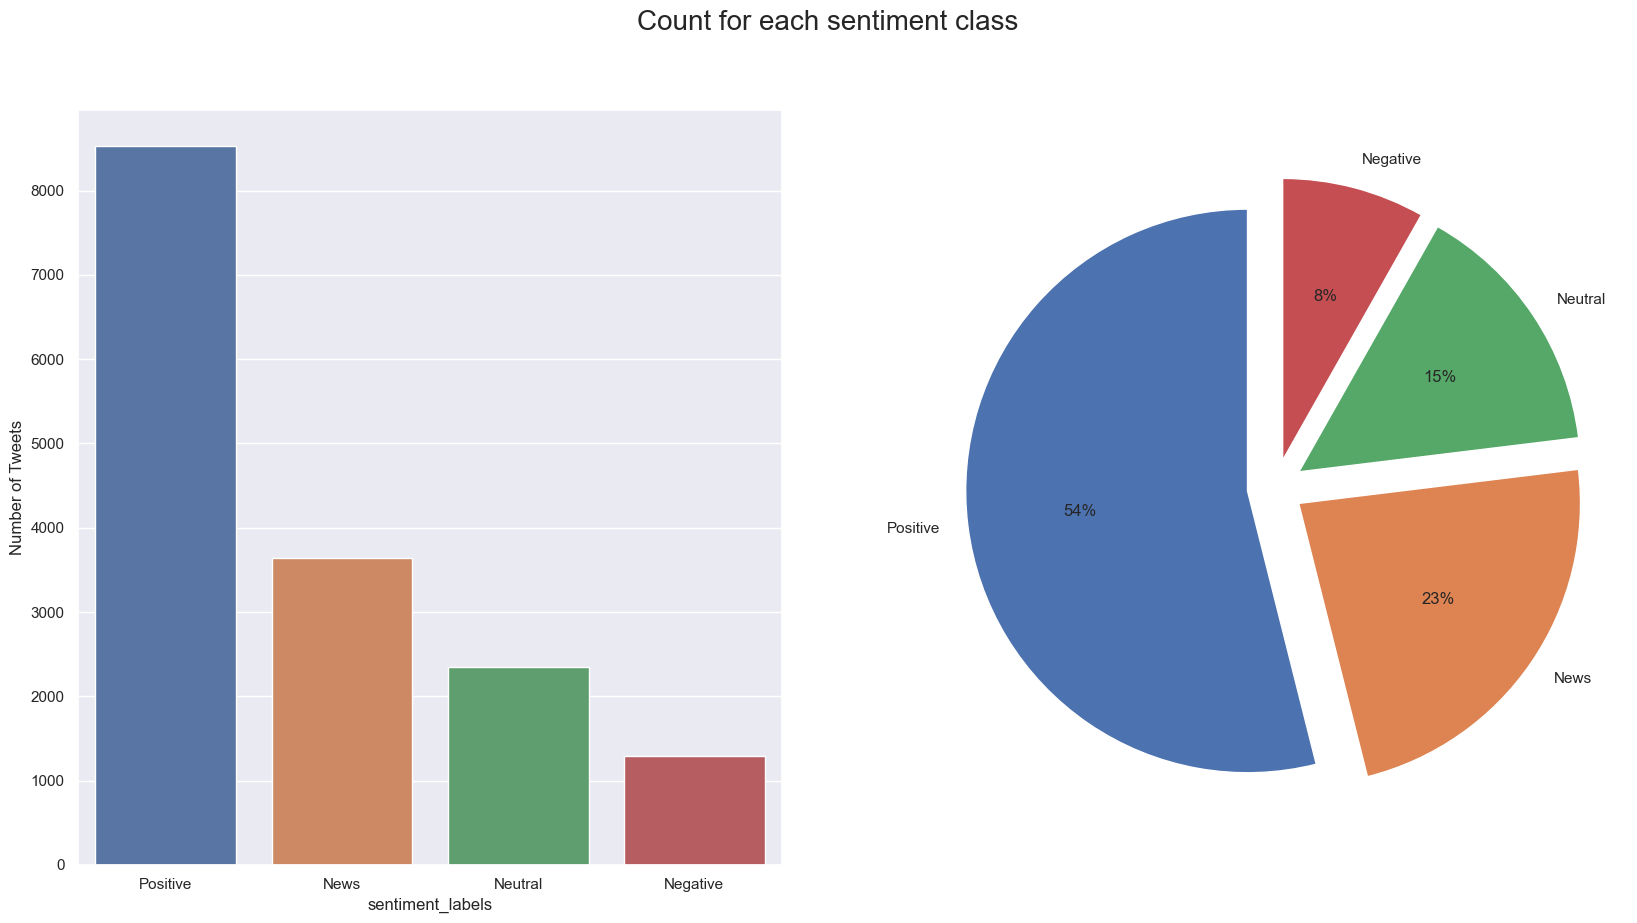

In [53]:
# exploring the distribution of the sentiments
train_EDA['sentiment_labels']  = train_df['sentiment'].map({-1:'Negative', 0:'Neutral', 1:'Positive', 2:'News'})

fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 10), dpi = 100)
sns.countplot(train_EDA['sentiment_labels'], ax = axes[0]).set_ylabel('Number of Tweets')

Sentiments_ = ['Positive', 'News', 'Neutral', 'Negative']
axes[1].pie(train_EDA['sentiment_labels'].value_counts(),
            labels = Sentiments_,
            autopct = '%1.0f%%',
            startangle = 90,
            explode = (0.1, 0.1, 0.1, 0.1))

fig.suptitle('Count for each sentiment class', fontsize=20)
plt.show()

From the above graphs we can that most of the tweets in our data belongs to individuals who are pro-climate change. Now let's do a quick analysis of the distribution of observations across our labels.

Text(0, 0.5, 'Density')

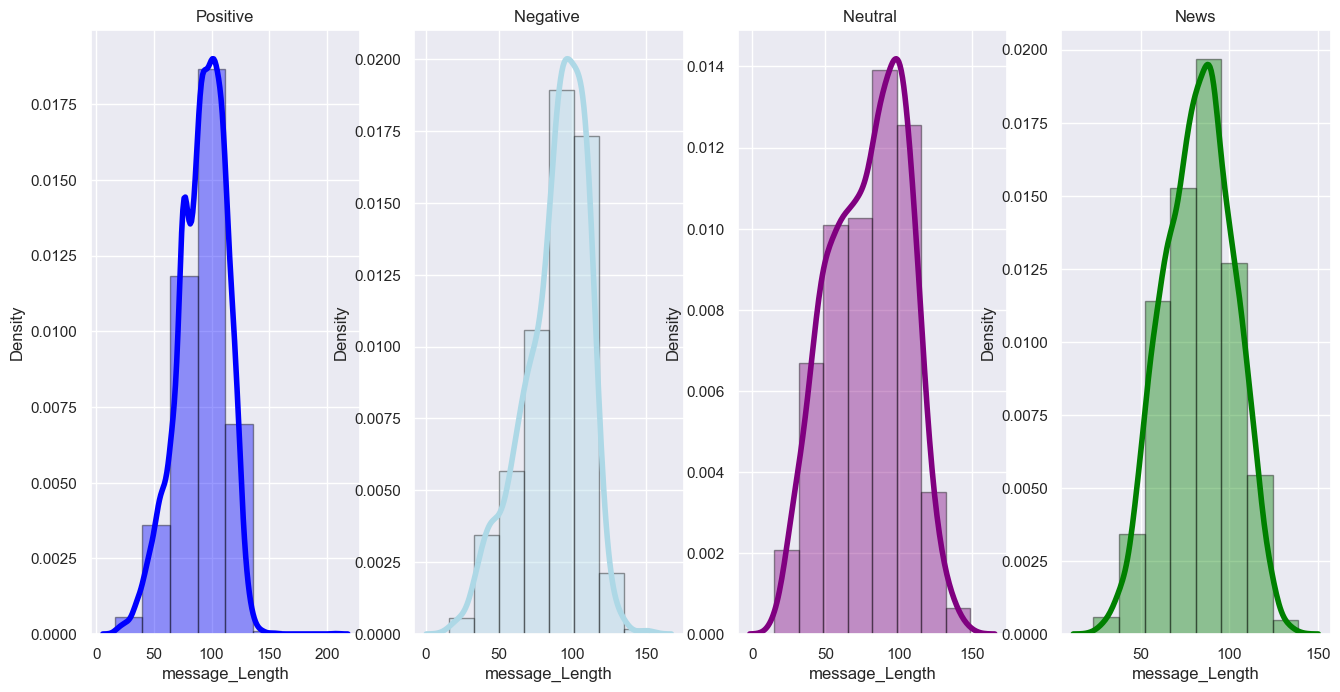

In [54]:
# Distribution plots for the labels
fig,(ax1,ax2,ax3,ax4) = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 8), dpi = 100)

#For Positive 
sns.distplot(train_df[train_df['sentiment'] == 1]['message'].str.len(), hist=True, kde=True, bins = int(200/25),
             color = 'blue', ax = ax1, hist_kws = {'edgecolor':'black'}, kde_kws = {'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train_df[train_df['sentiment'] == -1]['message'].str.len(), hist=True, kde=True, bins = int(200/25),
             color = 'lightblue', ax = ax2, hist_kws = {'edgecolor':'black'}, kde_kws = {'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train_df[train_df['sentiment'] == 0]['message'].str.len(), hist=True, kde=True, bins = int(200/25),
             color = 'purple', ax = ax3, hist_kws = {'edgecolor':'black'}, kde_kws = {'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For News
sns.distplot(train_df[train_df['sentiment'] == 2]['message'].str.len(), hist=True, kde=True, bins=int(200/25),
             color = 'green', ax = ax4, hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

A density plot is a representation of the distribution of a numeric variable .Looking at the four density graphs(for positive,negative,neutral and news) above we realise that the graphs above are not normally distributed,this means that they are not symetrical about the center and tend to be slightly skewed .

Taking a closer look at the negative density plot ,we realise that it has a slightly higher density than the rest of the graphs.Therefore the density count is signifigant for anti-climate change  

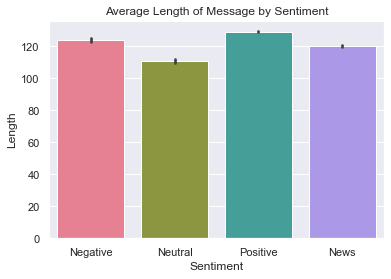

In [55]:
# Visualizing text lengths for each sentiment
labels = ['Negative', 'Neutral', 'Positive', 'News']
sns.barplot(x = 'sentiment', y = train_EDA['message'].apply(len), data = train_EDA, palette='husl').set_xticklabels(labels)
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

Sentiment analysis is a technique that detects the underlying sentiment in a piece of text.It is the process of classifying text as either positive, negative, neutral or news.

Observing the bar graph above of average length of message by sentiment:
We observe that:
* the postive sentiment(pro-climate change ) has a significantly higher length above 120 
* the negative sentiment (anti-climate change) also has a high length of sligtly above 120
* the news sentiment (tweets posted by news) has a length of 120
* the neutral sentiment( tweets with neutral massege) has a length of slightly above 100 they don't write long tweets as conmpared to the rest


#### 3.2 Exploring hashtags from users

In [56]:
# Creating a column of hastags users
train_EDA['users'] = [''.join(re.findall(r'@\w{,}', sentence.lower())) if '@' in sentence else np.nan for sentence in train_EDA.message]

# Creating a column of hastags
hashtag_df = train_EDA.message.str.lower().str.findall(r'#.*?(?=\s|$)')
hashtag_df = hashtag_df.apply(lambda x: np.nan if len(x) == 0 else x).replace(np.nan, 0)
hashtag_df = pd.DataFrame(hashtag_df)
hashtag_df = hashtag_df[hashtag_df['message'] != 0]

In [57]:
hashtag = sum(hashtag_df['message'], [])
count = nltk.FreqDist(hashtag)  
hashtag = pd.DataFrame({'hashtags': list(count.keys()), 'count': list(count.values())})
hashtag = hashtag.nlargest(20, columns="count")
hashtag.head()

,hashtags,count
18,#climate,344
23,#climatechange,188
21,#beforetheflood,154
51,#environment,73
143,#trump,70


A hashtag is a keyword or phrase preceded by the hash symbol (#), written within a post or comment to highlight it and facilitate a search for.Next we look at the  five hashtag counts .we observe that #climate has a significantly high count(344)  followed by #climatechange(188) which could imply that these are the most used hashtags to search. 

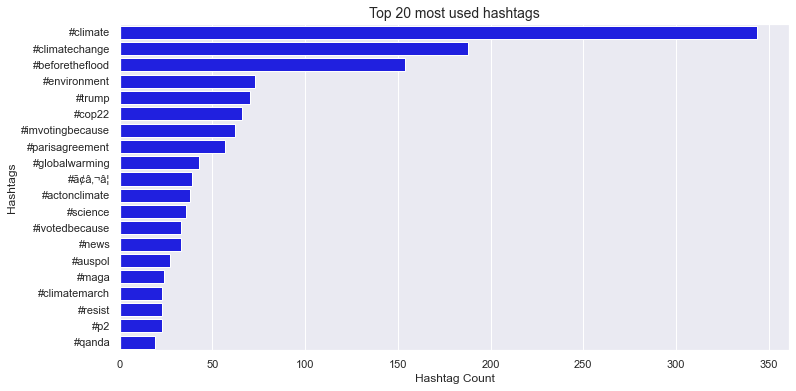

In [58]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(data = hashtag.iloc[:20], y = 'hashtags', x = 'count', orient='h', color = 'blue')
plt.title("Top 20 most used hashtags", fontsize = 14)
plt.xlabel('Hashtag Count')
plt.ylabel('Hashtags')
plt.show()

* **#climate** and **#climatechange** are expected to be the most popular as they are our key identifier in tweets, **#environment** is also in the top 20.
* **#BeforeTheFlood** surfaced after a documentary about environmental degradation that leads to global warming and suggestions on how to reduce it, narrated by Leonardo DiCaprio.
* In 2016, **Donald Trump** made headlines across news publications after describing climate change as a **'Hoax'** while he was running for presidency for USA, reason why **#trump** is seen in the top hashtags
* The **#cop22**, COP22 (Conference of the Parties) represents the United Nations Climate Change Conference in 2016.

#### 3.3 Exploring users 

In [61]:
# Number of messages per users
users = train_EDA[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending = False)
users.head()

,users,message
5876,@stephenschlegel,307
5618,@sensanders,243
5069,@realdonaldtrump,143
736,@berniesanders,121
1430,@cnn,106


Here we observe the first five number of message per user and @stephenschlegel has a significantly high message count of 307 this could be because stephen is the oerson that tweets the most while @sciam ,@fusion and @guardianeco have a very low cout and could potentially be outliers with the lowest popoular tags  

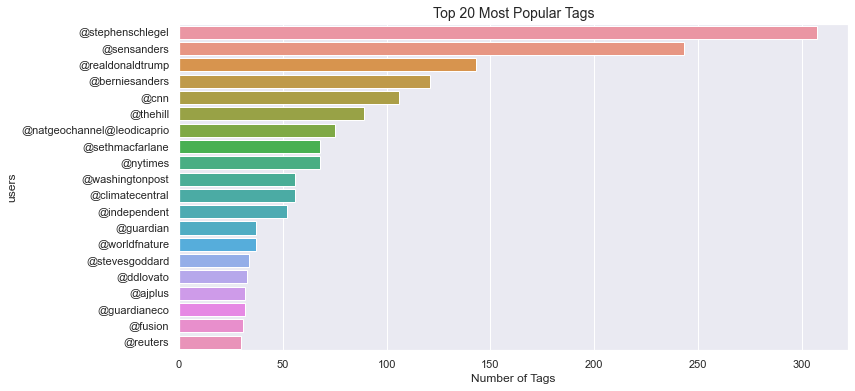

In [63]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(data = train_EDA, y = 'users', order = train_EDA.users.value_counts().iloc[:20].index, orient='h')
plt.title('Top 20 Most Popular Tags', fontsize = 14)
plt.xlabel('Number of Tags')
plt.ylabel('users')
plt.show()

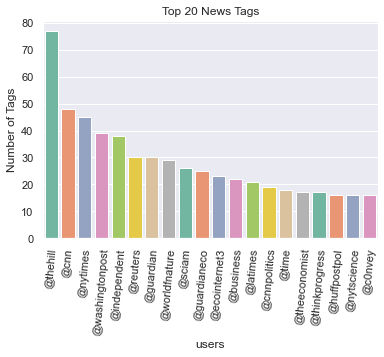

In [64]:
sns.countplot(x = "users", data = train_EDA[train_EDA['sentiment_labels'] == 'News'], palette='Set2',
              order=train_EDA[train_EDA['sentiment_labels'] == 'News'].users.value_counts().iloc[:20].index) 

plt.xlabel('users')
plt.ylabel('Number of Tags')
plt.title('Top 20 News Tags')
plt.xticks(rotation=85)
plt.show()

from bar graph above @thehill has the highest number of new tags 

### 3.4 Clouds of words for different tweets
We would now like to know which words are mostly used by individuals in these groups. We first split our data into four different classes.

 A word cloud is a textual data visualization which allows anyone to see in a single glance the words which have the highest frequency within a given body of text. Word clouds are typically used as a tool for processing, analyzing and disseminating qualitative sentiment data.

In [65]:
# Separate minority and majority classes
News = train_df[train_df['sentiment'] == 2]
Pro = train_df[train_df['sentiment'] == 1]
Neutral = train_df[train_df['sentiment'] == 0]
Anti = train_df[train_df['sentiment'] == -1]

#### Plot a cloud of words for anti-climate change tweets

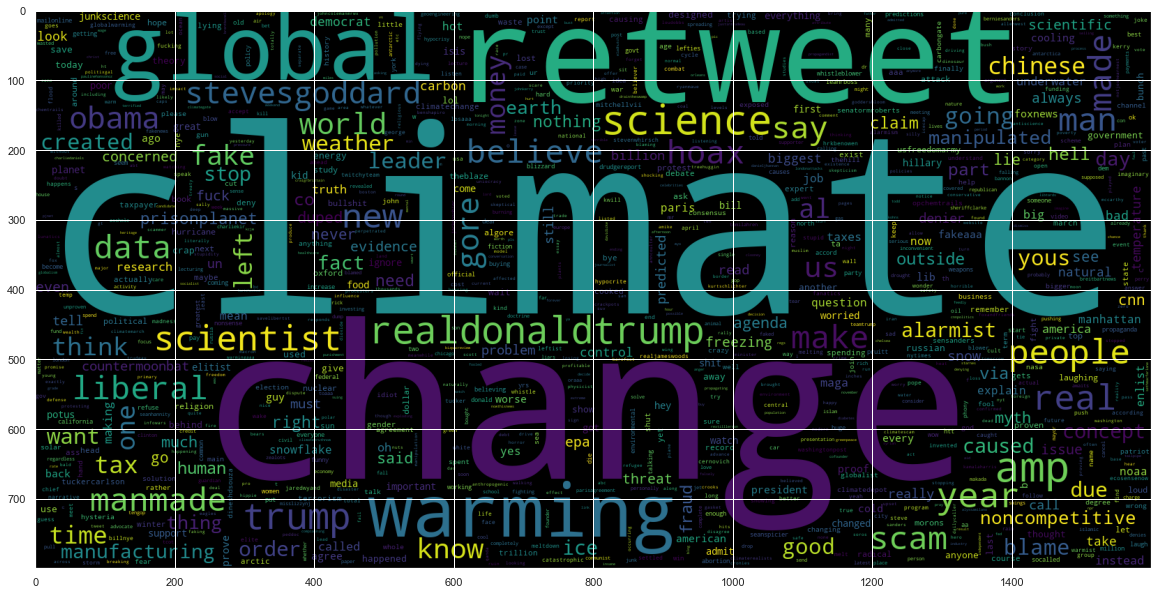

In [66]:
# word cloud
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations = False).generate(" ".join(Anti['message']))
plt.imshow(wc)

We see a lot of negative words such as `fake`, `scam`, `hoax`, `manipulated`, `manmade`, `chinese` ... etc. These are words which are mostly used by people who are against climate change. We can also see  Donald Trump since he doesn't believe in climate change and he was vocal about his believes.

#### Plot a cloud of words for pro-climate change tweets

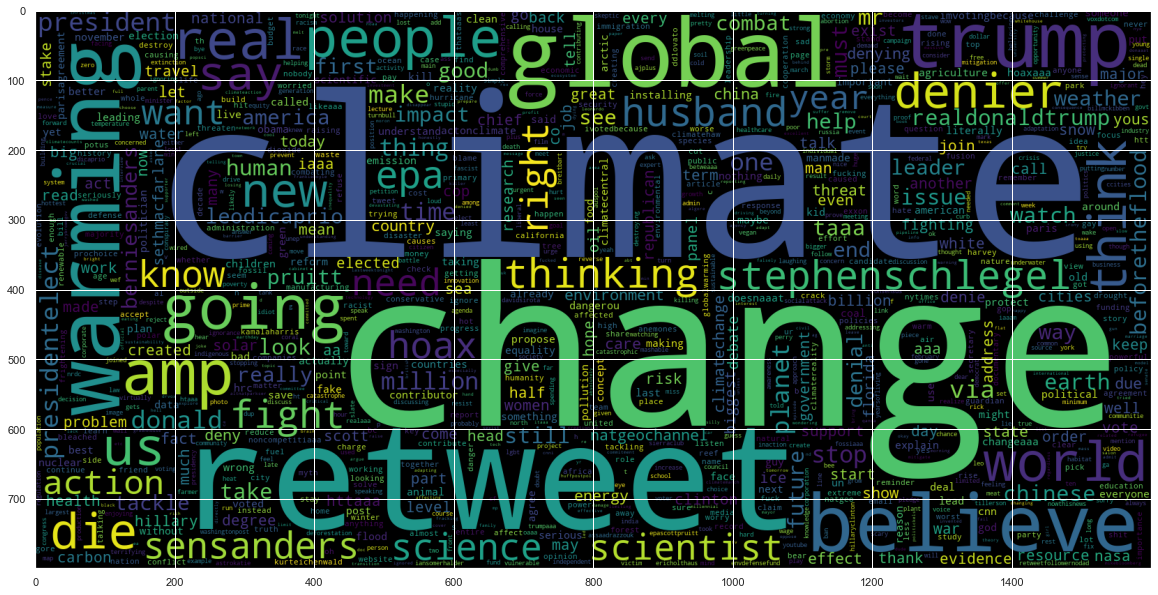

In [67]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations = False).generate(" ".join(Pro['message']))
plt.imshow(wc)

Here we see a lot of positive words, words that calls for help or action, words such as `believe`, `action`, `real`, `think`, `environment`, ... etc.

#### Plot a cloud of words for news networks tweets

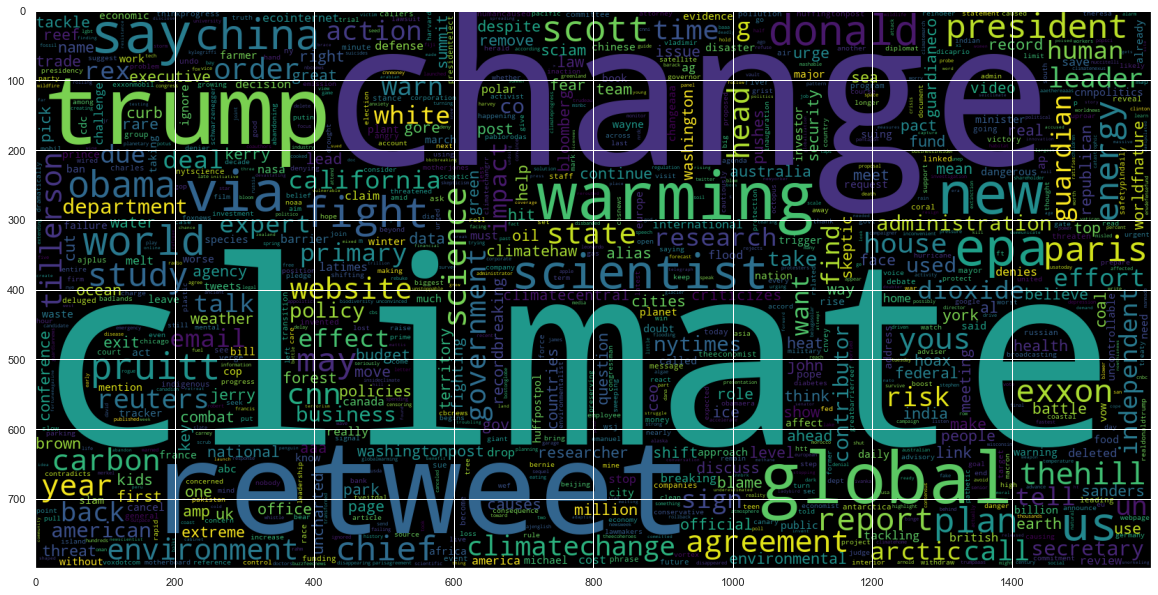

In [68]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations = False).generate(" ".join(News['message']))
plt.imshow(wc)

It looks like the news tweets are mostly retweets, we see words like `climatechange`, `environment`, `change`, `climate`, which is what we would expect considering the project is about climate change but we see words like `research`, `washingtonpost`, `cnn`,`scientist`, `study`, `expert`, `policies` which are unique to the news tweets.

###  Plot a cloud of words for neutral tweets

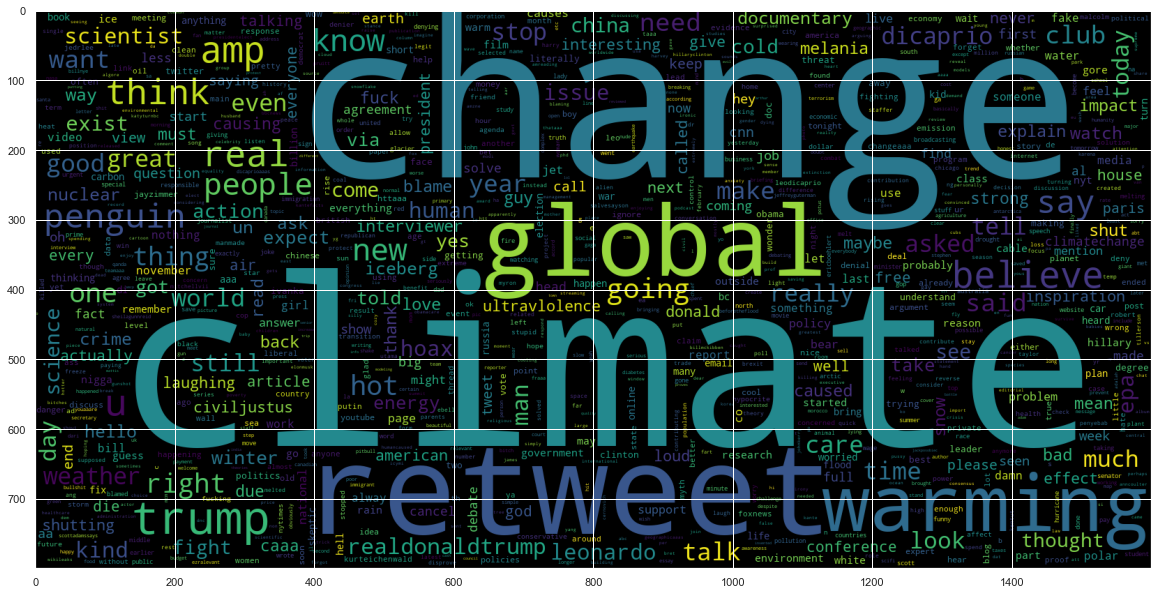

In [70]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations = False).generate(" ".join(Neutral['message']))
plt.imshow(wc)

Here we see words like such as `penguin`, `people`, `global` which are classified as neutral sentiment tweets. and we see words like `retweet` which suggest that also most of the tweets are retweets. the neutral tweets, they normally tweet about anything

## 4. Model Building
### 4.1 Feature Engineering
We have seen from the Exploratory Data Analysis that we have `class imbalance`. 

#### Upsampling the minority class

In [71]:
News_upsampled = resample(News, replace = True, n_samples = 8530, random_state=27)
Anti_upsampled = resample(Anti, replace = True, n_samples = 8530, random_state=27)
Neutral_upsampled = resample(Neutral, replace = True, n_samples = 8530, random_state=27)

In [45]:
#Pro_downsampled = resample(Pro, replace=False, n_samples = 8530, random_state=27)

In [72]:
# Combine downsampled majority class with minority class
balanced_df = pd.concat([Pro, News_upsampled, Anti_upsampled, Neutral_upsampled])

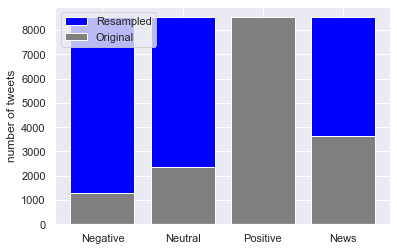

In [79]:
upsampled_heights = [len(Anti_upsampled), len(Neutral_upsampled), len(Pro), len(News_upsampled)]
heights = [len(train_df[train_df['sentiment'] == -1]), len(train_df[train_df['sentiment'] == 0]),
         len(train_df[train_df['sentiment'] == 1]), len(train_df[train_df['sentiment'] == 2])]

# Get all possible labels
labels = labels = ['Negative', 'Neutral', 'Positive', 'News']
plt.bar(labels, upsampled_heights, color = 'blue')
plt.bar(labels, heights, color = 'grey')
plt.ylabel("number of tweets")
plt.legend(['Resampled','Original'])
plt.show()

Now our data is balanced, we have upsampled so that all sentiments are of the same value count.

### 4.2 Feature Generation using Bag of Words

Next, we will use a count vectorizer from the Scikit-learn library.
This will transform the text in our data frame into a bag of words model, which will contain a sparse matrix of integers. The number of occurrences of each word will be counted and printed.
We will need to convert the text into a bag-of-words model since the logistic regression algorithm cannot understand text.

In [74]:
train = balanced_df.copy()
test = test_df.copy()

In [75]:
#tokenizer to remove unwanted elements from out data like symbols and numbers
stop = list(stopwords.words('english'))

cv = CountVectorizer(ngram_range = (1, 3))
#cv = TfidfVectorizer(stop_words = stop, tokenizer = tokeniser.tokenize, ngram_range = (1, 2), max_features = 80000)
X = cv.fit_transform(train['message'].values)
y = train['sentiment'].values

print("X shape : ", X.shape)
print("y shape : ", y.shape)

X shape :  (34120, 213326)
y shape :  (34120,)


### 4.3 Split train and test set

Now we split the data into training and testing,the ratio of traing is 80% and ratio of testing is 20%.X_train stores the independent feature for training and Y_train stores the dependent feature of training.

In [76]:
# splitting our data so we can easily evaluate the perfomance of our models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

### 4.4 Model Building and Evaluation
#### MultinomialNB

Here we define MultinimialNB naive-bayes algorithm which performs on the probability based and train using the X_train and Y_train data.And test the model using the X_test data.And to check the accuracy_score,classification_report,confusion_matrix with the y_test and pred.

In [77]:
# Using the Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

print("MultinomialNB Testing Accuracy Score: ", accuracy_score(y_test, predicted))
print("MultinomialNB Training Accuracy Score: ", clf.score(X_train, y_train))
print(classification_report(y_test, predicted))

MultinomialNB Testing Accuracy Score:  0.9070926143024619
MultinomialNB Training Accuracy Score:  0.9844991533150971
              precision    recall  f1-score   support

          -1       0.93      1.00      0.96       847
           0       0.91      0.96      0.94       885
           1       0.97      0.69      0.80       856
           2       0.85      0.98      0.91       824

    accuracy                           0.91      3412
   macro avg       0.91      0.91      0.90      3412
weighted avg       0.91      0.91      0.90      3412



The overall f1-score of the model on the test data is around 96%, which is shows that we have good results

#### Logistic Regression

A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

In [82]:
lr = LogisticRegression(C = 6, multi_class = 'ovr') 

lr.fit(X_train, y_train)
log_prediction = lr.predict(X_test)
log_accuracy = accuracy_score(y_test, log_prediction)

print("Logistic Regression Testing Accuracy Score: ", log_accuracy)
print(classification_report(y_test, log_prediction))

Logistic Regression Testing Accuracy Score:  0.9460726846424384
Logistic Regression Training Accuracy Score:  0.9989904910772437
              precision    recall  f1-score   support

          -1       0.98      0.99      0.99       847
           0       0.93      0.98      0.95       885
           1       0.95      0.83      0.89       856
           2       0.93      0.98      0.95       824

    accuracy                           0.95      3412
   macro avg       0.95      0.95      0.95      3412
weighted avg       0.95      0.95      0.94      3412



The overall f1-score of the model on the test data is around 99%, which shows that that is good since we won't look at the accuracy since we are dealing with class imbalance.

#### Support Vector Machine

In [80]:
svc = SVC(kernel='rbf')

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_test)
svc_accuracy = accuracy_score(y_test, svc_prediction)


print("Testing accuracy Score: ", svc_accuracy)

print(classification_report(svc_prediction, y_test))

Training accuracy Score:  0.9934219096001042
Testing accuracy Score:  0.9548651817116061
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99       846
           0       0.97      0.95      0.96       910
           1       0.89      0.94      0.91       813
           2       0.96      0.94      0.95       843

    accuracy                           0.95      3412
   macro avg       0.95      0.95      0.95      3412
weighted avg       0.96      0.95      0.96      3412



## 5. Model saving
### 5.1 Saving a model with Pickle

In [94]:
model_save_path = "svc.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svc, file)

### 5.2 Preprocessing: Predicting on the test set
We need to do is to get our data in the right format. to avoid getting errors

In [84]:
tweet_id = test['tweetid']
X_test_ = cv.transform(test['message'].values)

In [85]:
X_test_.shape

(10546, 213326)

### 5.3 Making predictions

In [90]:
preds = svc.predict(X_test_)
preds

### 5.4 Submission

In [92]:
# create submission dataframe
submission = pd.DataFrame(
    {'tweetid': tweet_id,
     'sentiment': preds
    })

In [93]:
# save DataFrame to csv file for submission
submission.to_csv("Classification1.csv", index=False)

## 6. Conclusion

We managed to make predictions and we had a high f1-score which shows that we balanced out precision and recall since we we had class imbalance we did not use accuracy to check the perfomance of our models.